# Load a test split

In [1]:
import os
import json
split_num=1
data_dir = "."
label_file = os.path.join(data_dir, "testset",f"testset_split_{split_num}_rawframes.txt")
prob_files = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith(f"_split{split_num}.json"):
            prob_files.append(os.path.join(root, file))

In [2]:
import numpy as np
participant = []
camera = []
segment = []
GT = []
with open(label_file, "r") as f:
    for line in f:
        labels_raw = line.strip().split(" ")
        participant.append(labels_raw[0].split("_")[1])
        camera.append(labels_raw[0].split("_")[3])
        segment.append(labels_raw[0].split("_")[7])
        GT.append(int(labels_raw[2]))
labels_raw = np.array(labels_raw)
probs = []
probs_flow = []
probs_rgb = []
for prob_file in prob_files:
    if ("flow" in prob_file):
        probs_flow.append(json.load(open(prob_file, "r")))
    elif("rgb" in prob_file):
        probs_rgb.append(json.load(open(prob_file, "r")))

    probs.append(json.load(open(prob_file, "r")))
probs_rgb = np.array(probs_rgb)
probs_flow = np.array(probs_flow)
probs_rgb = np.mean(probs_rgb, axis=0)
probs_flow = np.mean(probs_flow, axis=0)
probs = np.array(probs)
probs_avg = np.mean(probs, axis=0)
# probs_avg.shape

## Merge the predicted results to 1) Average between RGB_FLOW, RGB/Flow Alone

In [3]:
import pandas as pd
prob_avg_RGB_FLOW = pd.DataFrame({
        'Participant': participant,
        'Camera': camera,
        'Segment': segment,
        'Prob 0': probs_avg[:, 0], ## Other prob
        'Prob 1': probs_avg[:, 1],## EyeContact prob
        'GT': GT
})
prob_single_RGB = pd.DataFrame({
        'Participant': participant,
        'Camera': camera,
        'Segment': segment,
        'Prob 0': probs_rgb[:, 0], ## Other prob
        'Prob 1': probs_rgb[:, 1],## EyeContact prob
        'GT': GT
})
prob_single_FLOW = pd.DataFrame({
        'Participant': participant,
        'Camera': camera,
        'Segment': segment,
        'Prob 0': probs_flow[:, 0], ## Other prob
        'Prob 1': probs_flow[:, 1],## EyeContact prob
        'GT': GT
})


### Multiview on RGB Only

In [4]:
data_participant_segment_rgb = prob_single_RGB.groupby(["Participant","Segment","GT"]).agg(
                                {
                                    'Camera': list,
                                    'Prob 0': np.mean,
                                    'Prob 1': np.mean
                                })
data_participant_segment_rgb['Pred'] = np.where(data_participant_segment_rgb['Prob 0'] > data_participant_segment_rgb['Prob 1'], 
                                                0, 1)
data_participant_segment_rgb

Camera    Prob 0        Prob 1  Pred
Participant Segment GT                                                
Autism0001  1       0   [C1, C3, C2, C4]  0.992223  7.776808e-03     0
                    1   [C4, C3, C1, C2]  0.238791  7.612089e-01     1
            10      1   [C2, C1, C4, C3]  0.094819  9.051806e-01     1
            11      0   [C3, C2, C1, C4]  0.927710  7.229006e-02     0
            12      0   [C3, C4, C1, C2]  0.538160  4.618400e-01     0
...                                  ...       ...           ...   ...
Control0032 6       0   [C4, C3, C1, C2]  1.000000  7.383331e-08     0
            7       0   [C3, C2, C4, C1]  0.821956  1.780438e-01     0
            8       0   [C3, C2, C4, C1]  0.983521  1.647880e-02     0
Control0033 1       0   [C1, C3, C2, C4]  0.999977  2.251134e-05     0
            2       0   [C2, C1, C3, C4]  1.000000  9.969288e-11     0

[742 rows x 4 columns]

### Multiview on Flow Only

In [5]:
data_participant_segment_flow = prob_single_FLOW.groupby(["Participant","Segment","GT"]).agg(
                                {
                                    'Camera': list,
                                    'Prob 0': np.mean,
                                    'Prob 1': np.mean
                                })
data_participant_segment_flow['Pred'] = np.where(data_participant_segment_flow['Prob 0'] > data_participant_segment_flow['Prob 1'], 
                                                0, 1)
data_participant_segment_flow

Camera    Prob 0    Prob 1  Pred
Participant Segment GT                                            
Autism0001  1       0   [C1, C3, C2, C4]  0.998786  0.001214     0
                    1   [C4, C3, C1, C2]  0.275927  0.724073     1
            10      1   [C2, C1, C4, C3]  0.227845  0.772155     1
            11      0   [C3, C2, C1, C4]  0.848472  0.151528     0
            12      0   [C3, C4, C1, C2]  0.837121  0.162879     0
...                                  ...       ...       ...   ...
Control0032 6       0   [C4, C3, C1, C2]  0.919899  0.080101     0
            7       0   [C3, C2, C4, C1]  0.599302  0.400698     0
            8       0   [C3, C2, C4, C1]  0.636924  0.363076     0
Control0033 1       0   [C1, C3, C2, C4]  0.980560  0.019440     0
            2       0   [C2, C1, C3, C4]  0.964254  0.035746     0

[742 rows x 4 columns]

### Multiview on Averaged RGB/Flow

In [6]:
data_participant_segment = prob_avg_RGB_FLOW.groupby(["Participant","Segment","GT"]).agg(
                                {
                                    'Camera': list,
                                    'Prob 0': np.mean,
                                    'Prob 1': np.mean
                                })
data_participant_segment['Pred'] = np.where(data_participant_segment['Prob 0'] > data_participant_segment['Prob 1'], 
                                                0, 1)
data_participant_segment


Camera    Prob 0    Prob 1  Pred
Participant Segment GT                                            
Autism0001  1       0   [C1, C3, C2, C4]  0.995505  0.004495     0
                    1   [C4, C3, C1, C2]  0.257359  0.742641     1
            10      1   [C2, C1, C4, C3]  0.161332  0.838668     1
            11      0   [C3, C2, C1, C4]  0.888091  0.111909     0
            12      0   [C3, C4, C1, C2]  0.687640  0.312360     0
...                                  ...       ...       ...   ...
Control0032 6       0   [C4, C3, C1, C2]  0.959949  0.040051     0
            7       0   [C3, C2, C4, C1]  0.710629  0.289371     0
            8       0   [C3, C2, C4, C1]  0.810223  0.189777     0
Control0033 1       0   [C1, C3, C2, C4]  0.990269  0.009731     0
            2       0   [C2, C1, C3, C4]  0.982127  0.017873     0

[742 rows x 4 columns]

## Save the predictions into excel

In [7]:
# multiview RGB Channel
output = os.path.join(data_dir,"results",f"baseline_result_multiview_RGB_channel_split_{split_num}.xlsx")
data_participant_segment_rgb.to_excel(output)

In [8]:
# multiview Flow Channel
output = os.path.join(data_dir,"results", f"baseline_result_multiview_Flow_channel_split_{split_num}.xlsx")
data_participant_segment_flow.to_excel(output)

In [9]:
# multiview fusion
output = os.path.join(data_dir,"results", f"baseline_result_multiview_fusion_split_{split_num}.xlsx")
data_participant_segment.to_excel(output)

In [10]:
#single view RGB
prob_single_RGB['Pred'] = np.where(prob_single_RGB['Prob 0'] > prob_single_RGB['Prob 1'], 
                                                0, 1)
output_single = os.path.join(data_dir,"results", f"baseline_result_singleview_RGB_split_{split_num}.xlsx")
prob_single_RGB.to_excel(output_single)

In [11]:
#single view Flow
prob_single_FLOW['Pred'] = np.where(prob_single_FLOW['Prob 0'] > prob_single_FLOW['Prob 1'], 
                                                0, 1)
output_single = os.path.join(data_dir,"results", f"baseline_result_singleview_Flow_split_{split_num}.xlsx")
prob_single_FLOW.to_excel(output_single)

In [12]:
#single view fusion
prob_avg_RGB_FLOW['Pred'] = np.where(prob_avg_RGB_FLOW['Prob 0'] > prob_avg_RGB_FLOW['Prob 1'], 
                                                0, 1)
output_single =os.path.join(data_dir,"results", f"baseline_result_singleview_fusion_split_{split_num}.xlsx")
prob_avg_RGB_FLOW.to_excel(output_single)

# Single View Performance

In [13]:
import pandas as pd

results_table_single_rgb = pd.read_excel (os.path.join(data_dir,"results", f"baseline_result_singleview_RGB_split_{split_num}.xlsx"))
results_table_single_flow = pd.read_excel (os.path.join(data_dir,"results", f"baseline_result_singleview_Flow_split_{split_num}.xlsx"))
results_table_single_fusion = pd.read_excel (os.path.join(data_dir,"results", f"baseline_result_singleview_fusion_split_{split_num}.xlsx"))

In [14]:
results_table_single_rgb_cc = results_table_single_rgb[results_table_single_rgb["Participant"].str.contains('Control')]
results_table_single_rgb_cc
results_table_single_rgb_asd = results_table_single_rgb[results_table_single_rgb["Participant"].str.contains('Autism')]
results_table_single_rgb_asd

results_table_single_flow_cc = results_table_single_flow[results_table_single_flow["Participant"].str.contains('Control')]
results_table_single_flow_cc
results_table_single_flow_asd = results_table_single_flow[results_table_single_flow["Participant"].str.contains('Autism')]
results_table_single_flow_asd

results_table_single_fusion_cc = results_table_single_fusion[results_table_single_fusion["Participant"].str.contains('Control')]
results_table_single_fusion_cc
results_table_single_fusion_asd = results_table_single_fusion[results_table_single_fusion["Participant"].str.contains('Autism')]
results_table_single_fusion_asd

,Unnamed: 0,Participant,Camera,Segment,Prob 0,Prob 1,GT,Pred
1,1,Autism0102,C1,23,0.533965,0.466035,0,0
2,2,Autism0094,C2,2,0.665587,0.334413,0,0
3,3,Autism0005,C2,17,0.771069,0.228930,0,0
4,4,Autism0100,C1,7,0.178666,0.821334,1,1
5,5,Autism0012,C2,9,0.997949,0.002051,0,0
...,...,...,...,...,...,...,...,...
2909,2909,Autism0024,C2,3,0.071503,0.928497,1,1
2910,2910,Autism0104,C3,7,0.447505,0.552495,1,1
2912,2912,Autism0019,C2,2,0.931752,0.068248,0,0
2913,2913,Autism0080,C3,2,0.240683,0.759317,0,1


In [15]:
from sklearn.metrics import accuracy_score
y_true_single_rgb = results_table_single_rgb["GT"]
y_pred_single_rgb = results_table_single_rgb["Pred"]
print(accuracy_score(y_true_single_rgb, y_pred_single_rgb))

y_true_single_flow = results_table_single_flow["GT"]
y_pred_single_flow = results_table_single_flow["Pred"]
print(accuracy_score(y_true_single_flow, y_pred_single_flow))

y_true_single_fusion = results_table_single_fusion["GT"]
y_pred_single_fusion = results_table_single_fusion["Pred"]
print(accuracy_score(y_true_single_fusion, y_pred_single_fusion))

0.8624356775300172
0.8006861063464837
0.8895368782161235


In [16]:
from sklearn.metrics import accuracy_score
y_true_single_rgb_cc = results_table_single_rgb_cc["GT"]
y_pred_single_rgb_cc = results_table_single_rgb_cc["Pred"]
print(accuracy_score(y_true_single_rgb_cc, y_pred_single_rgb_cc))
y_true_single_rgb_asd = results_table_single_rgb_asd["GT"]
y_pred_single_rgb_asd = results_table_single_rgb_asd["Pred"]
print(accuracy_score(y_true_single_rgb_asd, y_pred_single_rgb_asd))

y_true_single_flow_cc = results_table_single_flow_cc["GT"]
y_pred_single_flow_cc = results_table_single_flow_cc["Pred"]
print(accuracy_score(y_true_single_flow_cc, y_pred_single_flow_cc))
y_true_single_flow_asd = results_table_single_flow_asd["GT"]
y_pred_single_flow_asd = results_table_single_flow_asd["Pred"]
print(accuracy_score(y_true_single_flow_asd, y_pred_single_flow_asd))

y_true_single_fusion_cc = results_table_single_fusion_cc["GT"]
y_pred_single_fusion_cc = results_table_single_fusion_cc["Pred"]
print(accuracy_score(y_true_single_fusion_cc, y_pred_single_fusion_cc))
y_true_single_fusion_asd = results_table_single_fusion_asd["GT"]
y_pred_single_fusion_asd = results_table_single_fusion_asd["Pred"]
print(accuracy_score(y_true_single_fusion_asd, y_pred_single_fusion_asd))

0.850328947368421
0.8656263545730386
0.8569078947368421
0.7858690940615518
0.8963815789473685
0.8877329865626354


In [17]:
from sklearn import metrics

report_single_rgb = metrics.classification_report(y_true_single_rgb,y_pred_single_rgb,digits=3,output_dict=True)
print(report_single_rgb)

report_single_flow = metrics.classification_report(y_true_single_flow, y_pred_single_flow,digits=3,output_dict=True)
print(report_single_flow)

report_single_fusion = metrics.classification_report(y_true_single_fusion, y_pred_single_fusion,digits=3,output_dict=True)
print(report_single_fusion)

{'0': {'precision': 0.8801004394224733, 'recall': 0.869727047146402, 'f1-score': 0.8748829953198128, 'support': 1612}, '1': {'precision': 0.8411497730711044, 'recall': 0.8534151957022257, 'f1-score': 0.8472380952380952, 'support': 1303}, 'accuracy': 0.8624356775300172, 'macro avg': {'precision': 0.8606251062467889, 'recall': 0.8615711214243138, 'f1-score': 0.861060545278954, 'support': 2915}, 'weighted avg': {'precision': 0.8626895583741598, 'recall': 0.8624356775300172, 'f1-score': 0.8625257724016384, 'support': 2915}}
{'0': {'precision': 0.8133738601823708, 'recall': 0.8300248138957816, 'f1-score': 0.8216149831132945, 'support': 1612}, '1': {'precision': 0.784251968503937, 'recall': 0.7643898695318496, 'f1-score': 0.7741935483870969, 'support': 1303}, 'accuracy': 0.8006861063464837, 'macro avg': {'precision': 0.7988129143431539, 'recall': 0.7972073417138157, 'f1-score': 0.7979042657501957, 'support': 2915}, 'weighted avg': {'precision': 0.8003564245538977, 'recall': 0.800686106346483

In [18]:
from sklearn import metrics

report_single_rgb_cc = metrics.classification_report(y_true_single_rgb_cc,y_pred_single_rgb_cc,digits=3,output_dict=True)
print(report_single_rgb_cc)
report_single_rgb_asd = metrics.classification_report(y_true_single_rgb_asd,y_pred_single_rgb_asd,digits=3,output_dict=True)
print(report_single_rgb_asd)

report_single_flow_cc = metrics.classification_report(y_true_single_flow_cc, y_pred_single_flow_cc,digits=3,output_dict=True)
print(report_single_flow_cc)
report_single_flow_asd = metrics.classification_report(y_true_single_flow_asd, y_pred_single_flow_asd,digits=3,output_dict=True)
print(report_single_flow_asd)

report_single_fusion_cc = metrics.classification_report(y_true_single_fusion_cc, y_pred_single_fusion_cc,digits=3,output_dict=True)
print(report_single_fusion_cc)
report_single_fusion_asd = metrics.classification_report(y_true_single_fusion_asd, y_pred_single_fusion_asd,digits=3,output_dict=True)
print(report_single_fusion_asd)

{'0': {'precision': 0.9116809116809117, 'recall': 0.8421052631578947, 'f1-score': 0.8755129958960328, 'support': 380}, '1': {'precision': 0.7665369649805448, 'recall': 0.8640350877192983, 'f1-score': 0.8123711340206186, 'support': 228}, 'accuracy': 0.850328947368421, 'macro avg': {'precision': 0.8391089383307282, 'recall': 0.8530701754385965, 'f1-score': 0.8439420649583257, 'support': 608}, 'weighted avg': {'precision': 0.8572519316682741, 'recall': 0.850328947368421, 'f1-score': 0.8518347976927526, 'support': 608}}
{'0': {'precision': 0.8711755233494364, 'recall': 0.8782467532467533, 'f1-score': 0.8746968472109944, 'support': 1232}, '1': {'precision': 0.8591549295774648, 'recall': 0.8511627906976744, 'f1-score': 0.8551401869158879, 'support': 1075}, 'accuracy': 0.8656263545730386, 'macro avg': {'precision': 0.8651652264634506, 'recall': 0.8647047719722138, 'f1-score': 0.8649185170634411, 'support': 2307}, 'weighted avg': {'precision': 0.8655742497018987, 'recall': 0.8656263545730386, 

# Multiview Performance

## Multiview RGB

In [19]:
import pandas as pd

multiview_rgb = pd.read_excel (os.path.join(data_dir,"results", f"baseline_result_multiview_RGB_channel_split_{split_num}.xlsx"))
multiview_rgb = multiview_rgb.fillna(method='ffill', axis=0)

results_table_multiview_rgb =multiview_rgb[["Pred","GT"]]

In [20]:
results_table_multiview_rgb_cc = multiview_rgb[multiview_rgb["Participant"].str.contains('Control')]
results_table_multiview_rgb_cc
results_table_multiview_rgb_asd = multiview_rgb[multiview_rgb["Participant"].str.contains('Autism')]
results_table_multiview_rgb_asd

,Participant,Segment,GT,Camera,Prob 0,Prob 1,Pred
0,Autism0001,1.0,0,"['C1', 'C3', 'C2', 'C4']",0.992223,0.007777,0
1,Autism0001,1.0,1,"['C4', 'C3', 'C1', 'C2']",0.238791,0.761209,1
2,Autism0001,10.0,1,"['C2', 'C1', 'C4', 'C3']",0.094819,0.905181,1
3,Autism0001,11.0,0,"['C3', 'C2', 'C1', 'C4']",0.927710,0.072290,0
4,Autism0001,12.0,0,"['C3', 'C4', 'C1', 'C2']",0.538160,0.461840,0
...,...,...,...,...,...,...,...
585,Autism0107,2.0,0,"['C3', 'C4', 'C1', 'C2']",0.643675,0.356325,0
586,Autism0107,3.0,0,"['C3', 'C1', 'C2', 'C4']",0.845146,0.154854,0
587,Autism0107,3.0,1,"['C4', 'C3', 'C2', 'C1']",0.018285,0.981715,1
588,Autism0107,4.0,0,"['C1', 'C3', 'C4', 'C2']",0.939390,0.060610,0


In [21]:
from sklearn.metrics import accuracy_score
y_true_multiview_rgb = results_table_multiview_rgb["GT"]
y_pred_multiview_rgb = results_table_multiview_rgb["Pred"]
accuracy_score(y_true_multiview_rgb, y_pred_multiview_rgb)

0.9339622641509434

In [22]:
from sklearn.metrics import accuracy_score
y_true_multiview_rgb_cc = results_table_multiview_rgb_cc["GT"]
y_pred_multiview_rgb_cc = results_table_multiview_rgb_cc["Pred"]
accuracy_score(y_true_multiview_rgb_cc, y_pred_multiview_rgb_cc)

0.9078947368421053

In [23]:
y_true_multiview_rgb_asd = results_table_multiview_rgb_asd["GT"]
y_pred_multiview_rgb_asd = results_table_multiview_rgb_asd["Pred"]
accuracy_score(y_true_multiview_rgb_asd, y_pred_multiview_rgb_asd)

0.940677966101695

In [24]:
from sklearn.metrics import precision_recall_curve
y_prob1_multiview_rgb= multiview_rgb["Prob 1"]
precision, recall, thresholds = precision_recall_curve(y_true_multiview_rgb, y_pred_multiview_rgb)
recall

array([1.        , 0.93693694, 0.        ])

In [25]:
from sklearn import metrics

report_multiview_rgb = metrics.classification_report(y_true_multiview_rgb,y_pred_multiview_rgb,digits=3,output_dict=True)
print(report_multiview_rgb)
report_multiview_rgb_cc = metrics.classification_report(y_true_multiview_rgb_cc,y_pred_multiview_rgb_cc,digits=3,output_dict=True)
print(report_multiview_rgb_cc)
report_multiview_rgb_asd = metrics.classification_report(y_true_multiview_rgb_asd,y_pred_multiview_rgb_asd,digits=3,output_dict=True)
print(report_multiview_rgb_asd)


{'0': {'precision': 0.9477611940298507, 'recall': 0.9315403422982885, 'f1-score': 0.9395807644882861, 'support': 409}, '1': {'precision': 0.9176470588235294, 'recall': 0.9369369369369369, 'f1-score': 0.9271916790490341, 'support': 333}, 'accuracy': 0.9339622641509434, 'macro avg': {'precision': 0.93270412642669, 'recall': 0.9342386396176128, 'f1-score': 0.9333862217686602, 'support': 742}, 'weighted avg': {'precision': 0.9342463597660974, 'recall': 0.9339622641509434, 'f1-score': 0.934020703233204, 'support': 742}}
{'0': {'precision': 0.9550561797752809, 'recall': 0.8947368421052632, 'f1-score': 0.9239130434782609, 'support': 95}, '1': {'precision': 0.8412698412698413, 'recall': 0.9298245614035088, 'f1-score': 0.8833333333333334, 'support': 57}, 'accuracy': 0.9078947368421053, 'macro avg': {'precision': 0.8981630105225611, 'recall': 0.9122807017543859, 'f1-score': 0.9036231884057971, 'support': 152}, 'weighted avg': {'precision': 0.9123863028357411, 'recall': 0.9078947368421053, 'f1-sc

## Multiview Flow

In [26]:
multiview_flow = pd.read_excel (os.path.join(data_dir,"results", f"baseline_result_multiview_Flow_channel_split_{split_num}.xlsx"))
multiview_flow = multiview_flow.fillna(method='ffill', axis=0)

results_table_multiview_flow =multiview_flow[["Pred","GT"]]
results_table_multiview_flow

,Pred,GT
0,0,0
1,1,1
2,1,1
3,0,0
4,0,0
...,...,...
737,0,0
738,0,0
739,0,0
740,0,0


In [27]:
results_table_multiview_flow_cc = multiview_flow[multiview_flow["Participant"].str.contains('Control')]
results_table_multiview_flow_cc
results_table_multiview_flow_asd = multiview_flow[multiview_flow["Participant"].str.contains('Autism')]
results_table_multiview_flow_asd

,Participant,Segment,GT,Camera,Prob 0,Prob 1,Pred
0,Autism0001,1.0,0,"['C1', 'C3', 'C2', 'C4']",0.998786,0.001214,0
1,Autism0001,1.0,1,"['C4', 'C3', 'C1', 'C2']",0.275927,0.724073,1
2,Autism0001,10.0,1,"['C2', 'C1', 'C4', 'C3']",0.227845,0.772155,1
3,Autism0001,11.0,0,"['C3', 'C2', 'C1', 'C4']",0.848472,0.151528,0
4,Autism0001,12.0,0,"['C3', 'C4', 'C1', 'C2']",0.837121,0.162879,0
...,...,...,...,...,...,...,...
585,Autism0107,2.0,0,"['C3', 'C4', 'C1', 'C2']",0.155866,0.844134,1
586,Autism0107,3.0,0,"['C3', 'C1', 'C2', 'C4']",0.998875,0.001125,0
587,Autism0107,3.0,1,"['C4', 'C3', 'C2', 'C1']",0.506301,0.493699,0
588,Autism0107,4.0,0,"['C1', 'C3', 'C4', 'C2']",0.921418,0.078582,0


In [28]:
from sklearn.metrics import accuracy_score
y_true_multiview_flow = results_table_multiview_flow["GT"]
y_pred_multiview_flow = results_table_multiview_flow["Pred"]
accuracy_score(y_true_multiview_flow, y_pred_multiview_flow)

0.8733153638814016

In [29]:
from sklearn.metrics import accuracy_score
y_true_multiview_flow_cc = results_table_multiview_flow_cc["GT"]
y_pred_multiview_flow_cc = results_table_multiview_flow_cc["Pred"]
accuracy_score(y_true_multiview_flow_cc, y_pred_multiview_flow_cc)

0.9210526315789473

In [30]:
from sklearn.metrics import accuracy_score
y_true_multiview_flow_asd = results_table_multiview_flow_asd["GT"]
y_pred_multiview_flow_asd = results_table_multiview_flow_asd["Pred"]
accuracy_score(y_true_multiview_flow_asd, y_pred_multiview_flow_asd)

0.8610169491525423

In [31]:
from sklearn.metrics import precision_recall_curve
y_prob1_multiview_flow= multiview_flow["Prob 1"]
precision, recall, thresholds = precision_recall_curve(y_true_multiview_flow, y_pred_multiview_flow)
recall

array([1.        , 0.83783784, 0.        ])

In [32]:
from sklearn import metrics

report_multiview_flow = metrics.classification_report(y_true_multiview_flow,y_pred_multiview_flow,digits=3,output_dict=True)
print(report_multiview_flow)
report_multiview_flow_cc = metrics.classification_report(y_true_multiview_flow_cc,y_pred_multiview_flow_cc,digits=3,output_dict=True)
print(report_multiview_flow_cc)
report_multiview_flow_asd = metrics.classification_report(y_true_multiview_flow_asd,y_pred_multiview_flow_asd,digits=3,output_dict=True)
print(report_multiview_flow_asd)


{'0': {'precision': 0.8723404255319149, 'recall': 0.902200488997555, 'f1-score': 0.8870192307692308, 'support': 409}, '1': {'precision': 0.8746081504702194, 'recall': 0.8378378378378378, 'f1-score': 0.8558282208588956, 'support': 333}, 'accuracy': 0.8733153638814016, 'macro avg': {'precision': 0.8734742880010672, 'recall': 0.8700191634176964, 'f1-score': 0.8714237258140632, 'support': 742}, 'weighted avg': {'precision': 0.8733581511443885, 'recall': 0.8733153638814016, 'f1-score': 0.8730211090709267, 'support': 742}}
{'0': {'precision': 0.946236559139785, 'recall': 0.9263157894736842, 'f1-score': 0.9361702127659575, 'support': 95}, '1': {'precision': 0.8813559322033898, 'recall': 0.9122807017543859, 'f1-score': 0.8965517241379309, 'support': 57}, 'accuracy': 0.9210526315789473, 'macro avg': {'precision': 0.9137962456715873, 'recall': 0.9192982456140351, 'f1-score': 0.9163609684519443, 'support': 152}, 'weighted avg': {'precision': 0.9219063240386368, 'recall': 0.9210526315789473, 'f1-s

## Multiview Fusion

In [33]:
multiview_fusion = pd.read_excel (os.path.join(data_dir,"results", f"baseline_result_multiview_fusion_split_{split_num}.xlsx"))
multiview_fusion = multiview_fusion.fillna(method='ffill', axis=0)

results_table_multiview_fusion=multiview_fusion[["Pred","GT"]]
results_table_multiview_fusion

,Pred,GT
0,0,0
1,1,1
2,1,1
3,0,0
4,0,0
...,...,...
737,0,0
738,0,0
739,0,0
740,0,0


In [34]:
results_table_multiview_fusion_cc = multiview_fusion[multiview_fusion["Participant"].str.contains('Control')]
results_table_multiview_fusion_cc
results_table_multiview_fusion_asd = multiview_fusion[multiview_fusion["Participant"].str.contains('Autism')]
results_table_multiview_fusion_asd

,Participant,Segment,GT,Camera,Prob 0,Prob 1,Pred
0,Autism0001,1.0,0,"['C1', 'C3', 'C2', 'C4']",0.995505,0.004495,0
1,Autism0001,1.0,1,"['C4', 'C3', 'C1', 'C2']",0.257359,0.742641,1
2,Autism0001,10.0,1,"['C2', 'C1', 'C4', 'C3']",0.161332,0.838668,1
3,Autism0001,11.0,0,"['C3', 'C2', 'C1', 'C4']",0.888091,0.111909,0
4,Autism0001,12.0,0,"['C3', 'C4', 'C1', 'C2']",0.687640,0.312360,0
...,...,...,...,...,...,...,...
585,Autism0107,2.0,0,"['C3', 'C4', 'C1', 'C2']",0.399771,0.600229,1
586,Autism0107,3.0,0,"['C3', 'C1', 'C2', 'C4']",0.922010,0.077990,0
587,Autism0107,3.0,1,"['C4', 'C3', 'C2', 'C1']",0.262293,0.737707,1
588,Autism0107,4.0,0,"['C1', 'C3', 'C4', 'C2']",0.930404,0.069596,0


In [35]:
from sklearn.metrics import accuracy_score
y_true_multiview_fusion = results_table_multiview_fusion["GT"]
y_pred_multiview_fusion = results_table_multiview_fusion["Pred"]
accuracy_score(y_true_multiview_fusion, y_pred_multiview_fusion)

0.9501347708894878

In [36]:
from sklearn.metrics import accuracy_score
y_true_multiview_fusion_cc = results_table_multiview_fusion_cc["GT"]
y_pred_multiview_fusion_cc = results_table_multiview_fusion_cc["Pred"]
accuracy_score(y_true_multiview_fusion_cc, y_pred_multiview_fusion_cc)

0.9736842105263158

In [37]:
from sklearn.metrics import accuracy_score
y_true_multiview_fusion_asd = results_table_multiview_fusion_asd["GT"]
y_pred_multiview_fusion_asd = results_table_multiview_fusion_asd["Pred"]
accuracy_score(y_true_multiview_fusion_asd, y_pred_multiview_fusion_asd)

0.9440677966101695

In [38]:
from sklearn.metrics import precision_recall_curve
y_prob1_multiview_fusion= multiview_fusion["Prob 1"]
precision, recall, thresholds = precision_recall_curve(y_true_multiview_fusion, y_pred_multiview_fusion)
recall

array([1.        , 0.95195195, 0.        ])

In [39]:
from sklearn import metrics

report_multiview_fusion = metrics.classification_report(y_true_multiview_fusion,y_pred_multiview_fusion,digits=3,output_dict=True)
print(report_multiview_fusion)
report_multiview_fusion_cc = metrics.classification_report(y_true_multiview_fusion_cc,y_pred_multiview_fusion_cc,digits=3,output_dict=True)
print(report_multiview_fusion_cc)
report_multiview_fusion_asd = metrics.classification_report(y_true_multiview_fusion_asd,y_pred_multiview_fusion_asd,digits=3,output_dict=True)
print(report_multiview_fusion_asd)


{'0': {'precision': 0.9603960396039604, 'recall': 0.9486552567237164, 'f1-score': 0.9544895448954489, 'support': 409}, '1': {'precision': 0.9378698224852071, 'recall': 0.9519519519519519, 'f1-score': 0.9448584202682564, 'support': 333}, 'accuracy': 0.9501347708894878, 'macro avg': {'precision': 0.9491329310445837, 'recall': 0.9503036043378341, 'f1-score': 0.9496739825818526, 'support': 742}, 'weighted avg': {'precision': 0.9502865648053824, 'recall': 0.9501347708894878, 'f1-score': 0.9501672207703072, 'support': 742}}
{'0': {'precision': 1.0, 'recall': 0.9578947368421052, 'f1-score': 0.978494623655914, 'support': 95}, '1': {'precision': 0.9344262295081968, 'recall': 1.0, 'f1-score': 0.9661016949152543, 'support': 57}, 'accuracy': 0.9736842105263158, 'macro avg': {'precision': 0.9672131147540983, 'recall': 0.9789473684210526, 'f1-score': 0.9722981592855842, 'support': 152}, 'weighted avg': {'precision': 0.9754098360655737, 'recall': 0.9736842105263158, 'f1-score': 0.9738472753781666, 's

In [40]:
report_multiview_fusion_asd["0"]["f1-score"]

0.9473684210526315

## Code used in publication - Eye Contact Overall PR Curve

In [41]:
import numpy as np
from numpy import sqrt 

from sklearn import metrics
import matplotlib.pyplot as plt
from itertools import cycle
import pandas as pd
# Function to calculate Precision and Recall

def calc_precision_recall(y_true, y_pred):

    # Instantiate counters
    TP = 0
    FP = 0
    FN = 0

    # Determine whether each prediction is TP, FP, TN, or FN
    for i in range(y_true.shape[0]): 
        if y_true[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_true[i]!=y_pred[i]:
           FP += 1
        if y_pred[i]==0 and y_true[i]!=y_pred[i]:
           FN += 1
    
    # Calculate true positive rate and false positive rate
    # Use try-except statements to avoid problem of dividing by 0
    try:
        precision = TP / (TP + FP)
    except:
        precision = 10
    
    try:
        recall = TP / (TP + FN)
    except:
        recall = 10

    return precision, recall

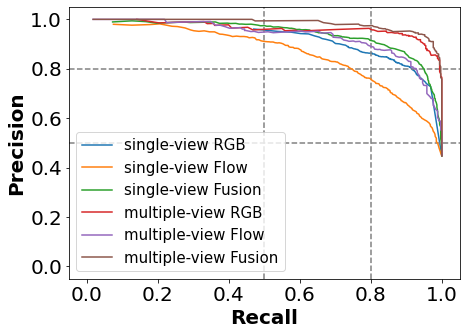

In [42]:
pal = "Set2"
f, ax = plt.subplots(figsize=(7, 5))
precision_scores = []
recall_scores = []
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
thresholds = [] # to store thresholds not causing division by zero error
# Define probability thresholds to use, between 0 and 1
probability_thresholds = np.linspace(0, 1, num=200)

# Find true positive / false positive rate for each threshold
for p in probability_thresholds:            
    precision, recall = calc_precision_recall(y_true_single_rgb, prob_single_RGB['Prob 1']>p)
    if precision < 10 and recall < 10:
    
        precision_scores.append(precision)
        recall_scores.append(recall)
        thresholds.append(p)

# fig,ax = plt.subplots(1,1, figsize=(12,4))
# fig.tight_layout()
ax = plt.plot(recall_scores, precision_scores,label="single-view RGB")
ax = plt.axhline(y=0.5, color='grey', linestyle='--')
ax = plt.axvline(x=0.5, color='grey', linestyle='--')
ax = plt.axhline(y=0.8, color='grey', linestyle='--')
ax = plt.axvline(x=0.8, color='grey', linestyle='--')


precision_scores = []
recall_scores = []

thresholds = [] # to store thresholds not causing division by zero error
# Find true positive / false positive rate for each threshold
for p in probability_thresholds:            
    precision, recall = calc_precision_recall(y_true_single_flow, prob_single_FLOW['Prob 1']>p)
    if precision < 10 and recall < 10:
    
        precision_scores.append(precision)
        recall_scores.append(recall)
        thresholds.append(p)
ax = plt.plot(recall_scores, precision_scores,label="single-view Flow")

precision_scores = []
recall_scores = []
thresholds = [] # to store thresholds not causing division by zero error
# Find true positive / false positive rate for each threshold
for p in probability_thresholds:            
    precision, recall = calc_precision_recall(y_true_single_fusion, prob_avg_RGB_FLOW['Prob 1']>p)
    if precision < 10 and recall < 10:
    
        precision_scores.append(precision)
        recall_scores.append(recall)
        thresholds.append(p)
ax = plt.plot(recall_scores, precision_scores,label="single-view Fusion")

precision_scores = []
recall_scores = []

thresholds = [] # to store thresholds not causing division by zero error
# Find true positive / false positive rate for each threshold
for p in probability_thresholds:            
    precision, recall = calc_precision_recall(y_true_multiview_rgb,y_prob1_multiview_rgb>p)
    if precision < 10 and recall < 10:
    
        precision_scores.append(precision)
        recall_scores.append(recall)
        thresholds.append(p)
ax = plt.plot(recall_scores, precision_scores,label="multiple-view RGB")

precision_scores = []
recall_scores = []

thresholds = [] # to store thresholds not causing division by zero error
# Find true positive / false positive rate for each threshold
for p in probability_thresholds:            
    precision, recall = calc_precision_recall(y_true_multiview_flow, y_prob1_multiview_flow>p)
    if precision < 10 and recall < 10:
    
        precision_scores.append(precision)
        recall_scores.append(recall)
        thresholds.append(p)
ax = plt.plot(recall_scores, precision_scores,label="multiple-view Flow")

precision_scores = []
recall_scores = []
thresholds = [] # to store thresholds not causing division by zero error
# Find true positive / false positive rate for each threshold
for p in probability_thresholds:            
    precision, recall = calc_precision_recall(y_true_multiview_fusion,y_prob1_multiview_fusion>p)
    if precision < 10 and recall < 10:
    
        precision_scores.append(precision)
        recall_scores.append(recall)
        thresholds.append(p)
ax = plt.plot(recall_scores, precision_scores,label="multiple-view Fusion")
plt.ylim(-0.05,1.05)
plt.xlim(-0.05,1.05)

plt.xlabel('Recall', fontsize=20,weight="bold")
plt.ylabel('Precision', fontsize=20,weight="bold")
plt.legend(fontsize=15)
plt.savefig(fname=".//results//MSBR PR curve Eye Contact.png",dpi=1200)

In [43]:
report_single_rgb_cc["0"]["f1-score"]
report_single_flow_cc["0"]["f1-score"]
report_single_fusion_cc["0"]["f1-score"]
report_multiview_rgb_cc["0"]["f1-score"]
report_multiview_flow_cc["0"]["f1-score"]
report_multiview_fusion_cc["0"]["f1-score"]

0.978494623655914

In [44]:
report_single_rgb_asd["0"]["f1-score"]
report_single_flow_asd["0"]["f1-score"]
report_single_fusion_asd["0"]["f1-score"]
report_multiview_rgb_asd["0"]["f1-score"]
report_multiview_flow_asd["0"]["f1-score"]
report_multiview_fusion_asd["0"]["f1-score"]

0.9473684210526315

In [45]:
cc_f1s_other =[report_single_rgb_cc["0"]["f1-score"],
report_single_flow_cc["0"]["f1-score"],
report_single_fusion_cc["0"]["f1-score"],
report_multiview_rgb_cc["0"]["f1-score"],
report_multiview_flow_cc["0"]["f1-score"],
report_multiview_fusion_cc["0"]["f1-score"]]
cc_f1s_other
asd_f1s_other =[report_single_rgb_asd["0"]["f1-score"],
report_single_flow_asd["0"]["f1-score"],
report_single_fusion_asd["0"]["f1-score"],
report_multiview_rgb_asd["0"]["f1-score"],
report_multiview_flow_asd["0"]["f1-score"],
report_multiview_fusion_asd["0"]["f1-score"]]
asd_f1s_other=[i * 100 for i in asd_f1s_other]
cc_f1s_other =[i * 100 for i in cc_f1s_other]
asd_f1s_other

[87.46968472109944,
 80.33439490445859,
 89.6275530636764,
 94.41786283891547,
 87.26708074534162,
 94.73684210526315]

In [46]:
cc_f1s_eyecontact =[report_single_rgb_cc["1"]["f1-score"],
report_single_flow_cc["1"]["f1-score"],
report_single_fusion_cc["1"]["f1-score"],
report_multiview_rgb_cc["1"]["f1-score"],
report_multiview_flow_cc["1"]["f1-score"],
report_multiview_fusion_cc["1"]["f1-score"]]

asd_f1s_eyecontact =[report_single_rgb_asd["1"]["f1-score"],
report_single_flow_asd["1"]["f1-score"],
report_single_fusion_asd["1"]["f1-score"],
report_multiview_rgb_asd["1"]["f1-score"],
report_multiview_flow_asd["1"]["f1-score"],
report_multiview_fusion_asd["1"]["f1-score"]]
asd_f1s_eyecontact=[i * 100 for i in asd_f1s_eyecontact]
cc_f1s_eyecontact =[i * 100 for i in cc_f1s_eyecontact]
asd_f1s_eyecontact

[85.51401869158879,
 76.49857278782112,
 87.76570618800189,
 93.67088607594937,
 84.70149253731343,
 94.03254972875226]

Text(0, 0.5, 'F1-score (%)')

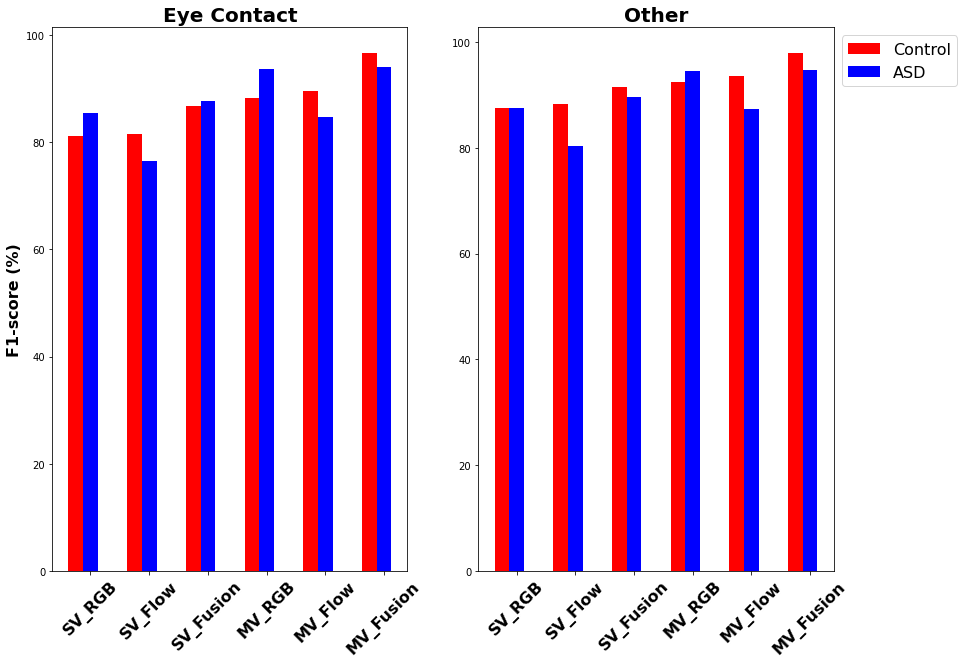

In [47]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 10))
# plt.rc('ytick', labelsize=20) 
# plt.rc('xtick', labelsize=20) 
# fig, ax = plt.subplots()

N =6
ind =np.arange(N)
width =0.25
plt.subplot(1,2,2)
bar1 =plt.bar(ind,cc_f1s_other,width,color='r')
bar2 =plt.bar(ind+width,asd_f1s_other,width,color='b')
plt.xticks(ind+width,['SV_RGB', 'SV_Flow', 'SV_Fusion','MV_RGB', 'MV_Flow', 'MV_Fusion'], rotation=45,fontsize=16,weight="bold")
# plt.legend( (bar1, bar2), ('Control', 'ASD'),bbox_to_anchor=(1, 1), fontsize=16)
plt.title("Other", fontsize=20,fontweight="bold")
plt.legend( (bar1, bar2), ('Control', 'ASD'), fontsize=16,bbox_to_anchor=(1, 1))

plt.subplot(1,2,1)
bar1 =plt.bar(ind,cc_f1s_eyecontact,width,color='r')
bar2 =plt.bar(ind+width,asd_f1s_eyecontact,width,color='b')
plt.xticks(ind+width,['SV_RGB', 'SV_Flow', 'SV_Fusion','MV_RGB', 'MV_Flow', 'MV_Fusion'],rotation = 45, fontsize=16,weight="bold")
plt.title("Eye Contact", fontsize=20,fontweight="bold")
plt.ylabel('F1-score (%)', fontsize=16,weight="bold")  

# plt.savefig(fname="F1-score both class.png",dpi=1200)

# ax.bar_label(bars)

In [48]:
cc_f1s_eyecontact

[81.23711340206185,
 81.52866242038218,
 86.84759916492693,
 88.33333333333334,
 89.6551724137931,
 96.61016949152543]

In [49]:
asd_f1s_eyecontact

[85.51401869158879,
 76.49857278782112,
 87.76570618800189,
 93.67088607594937,
 84.70149253731343,
 94.03254972875226]

Text(0.5, 1.0, 'Classification Performance: Other')

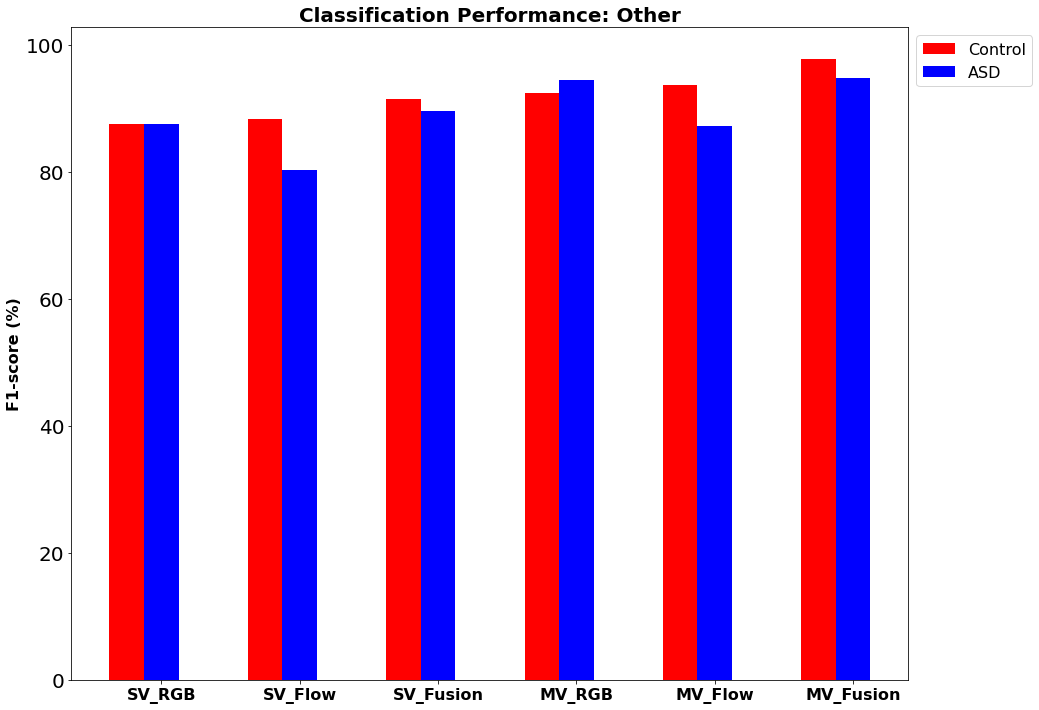

In [50]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 12))
plt.rc('ytick', labelsize=20) 


N =6
ind =np.arange(N)
width =0.25

bar1 = plt.bar(ind,cc_f1s_other,width,color='r')
bar2 = plt.bar(ind+width,asd_f1s_other,width,color='b')
plt.ylabel('F1-score (%)', fontsize=16,weight="bold")  
plt.xticks(ind+width,['SV_RGB', 'SV_Flow', 'SV_Fusion','MV_RGB', 'MV_Flow', 'MV_Fusion'], fontsize=16,weight="bold")
plt.legend( (bar1, bar2), ('Control', 'ASD'),bbox_to_anchor=(1, 1), fontsize=16)
plt.title("Classification Performance: Other", fontsize=20,fontweight="bold")
# plt.savefig(fname="F1-score comparision Other.png",dpi=1200)

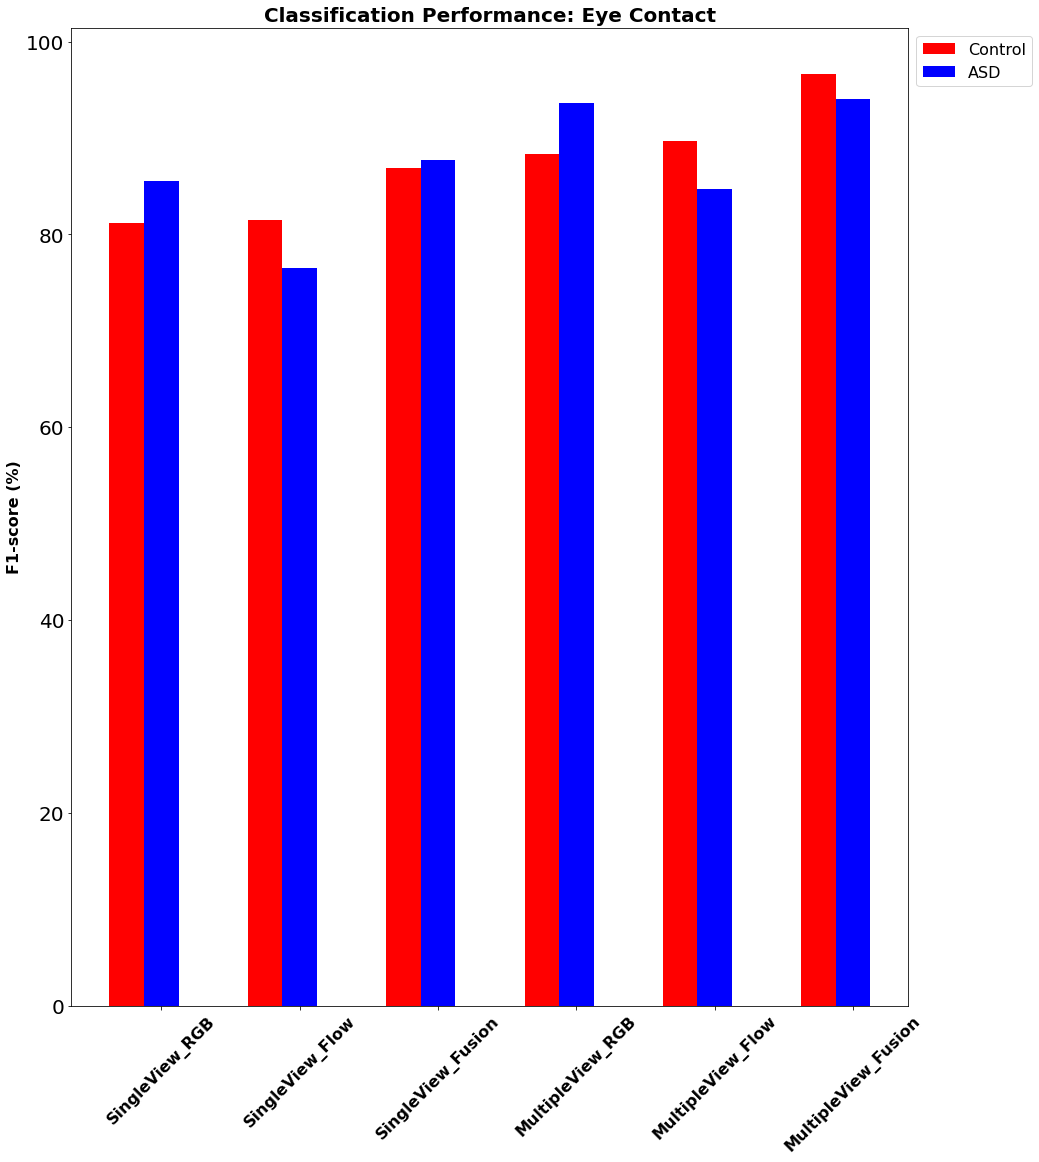

In [51]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 18))
plt.rc('ytick', labelsize=20) 

N =6
ind =np.arange(N)
width =0.25

bar1 = plt.bar(ind,cc_f1s_eyecontact,width,color='r')
bar2 = plt.bar(ind+width,asd_f1s_eyecontact,width,color='b')
plt.ylabel('F1-score (%)', fontsize=16,weight="bold")  
plt.xticks(ind+width,['SingleView_RGB', 'SingleView_Flow', 'SingleView_Fusion','MultipleView_RGB', 'MultipleView_Flow', 'MultipleView_Fusion'],rotation = 45, fontsize=16,weight="bold")
plt.legend( (bar1, bar2), ('Control', 'ASD'),bbox_to_anchor=(1, 1), fontsize=16)
plt.title("Classification Performance: Eye Contact", fontsize=20,fontweight="bold")
plt.savefig(fname=".//results//F1-score comparision Eye Contact.png",dpi=1200)